In [1]:
import os
import sys

try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))  
if project_root not in sys.path:
    sys.path.append(project_root)


In [3]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils_elicitation import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree

In [44]:
filtered_df = pd.read_csv("filtered_df.csv")
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0,artist,238709,0
1,9,169510,0,artist,169510,0
2,9,208084,70,artist,208084,0
3,9,245398,0,artist,245398,0
4,9,153166,0,artist,153166,0
...,...,...,...,...,...,...
1524889,248947,83754,30,artist,83754,0
1524890,248947,141799,0,genre,0,[141799]
1524891,248947,141677,0,artist,141677,0
1524892,248947,262458,0,artist,262458,0


In [45]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))


In [46]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [47]:
print(get_item_type(238709))  
print(get_item_type(141799))  


artist
genre


In [48]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

# Example ratios from 10% to 50%
# ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
# splits = {r: split_users_by_ratio(all_user_ids, r) for r in ratios}


## 10% warm

In [56]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.1)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")



In [57]:
df_warm

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0,artist,238709,0
1,9,169510,0,artist,169510,0
2,9,208084,70,artist,208084,0
3,9,245398,0,artist,245398,0
4,9,153166,0,artist,153166,0
...,...,...,...,...,...,...
143781,24286,253660,30,artist,253660,0
143782,24286,293466,10,artist,293466,0
143783,24286,178994,90,artist,178994,0
143784,24286,219001,0,artist,219001,0


In [58]:
df_cold

,user_id,item_id,rating,item_type,artist_id,genre_ids
143786,24414,267421,0,artist,267421,0
143787,24414,279057,0,artist,279057,0
143788,24414,60300,30,artist,60300,0
143789,24414,121430,0,artist,121430,0
143790,24414,164412,30,artist,164412,0
...,...,...,...,...,...,...
1524889,248947,83754,30,artist,83754,0
1524890,248947,141799,0,genre,0,[141799]
1524891,248947,141677,0,artist,141677,0
1524892,248947,262458,0,artist,262458,0


In [59]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold


In [64]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")


In [65]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1531
Cold items in X: 4793
test users in test: 1479
test items in test: 3898
train users in train: 692
train items in train: 574
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


In [66]:
print(f"Cold users in X: {len(np.unique(X_cold_hybrid.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_hybrid.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_hybrid.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_hybrid.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_hybrid.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_hybrid.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_hybrid.shape}")
print(f"Shape of train_cold: {train_cold_K_hybrid.shape}")
print(f"Shape of X_cold: {X_cold_hybrid.shape}")

Cold users in X: 1531
Cold items in X: 5011
test users in test: 1475
test items in test: 3980
train users in train: 689
train items in train: 587
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


Cold users in X: 1531
Cold items in X: 4793
test users in test: 1478
test items in test: 3907
train users in train: 666
train items in train: 571
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)

In [29]:
def elicitation_by_tree_path_fixed_warm(
    tree_model_class,
    train, test, X,
    matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5
):
    """
    Method 1 (revised): Fixed tree + fixed path elicitation, but tree is trained with warm + cold data.
    User paths are still based only on initial cold ratings.

    Parameters:
    - tree_model_class: tree class, not instance
    - train: cold users' initial ratings (lil_matrix)
    - test: cold users' test set (lil_matrix)
    - X: cold users' to-be-elicited ratings (lil_matrix)
    - matrix_warm: warm users' full ratings (lil_matrix)
    - idx_to_rid_cold, idx_to_rid_warm, idx_to_cid: index mappings
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """
    from surprise import Dataset, Reader, SVD, accuracy

    num_users, num_items = train.shape
    train_static = train.tolil().copy()
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    user_paths = {u: None for u in range(num_users)}
    rmse_list, mae_list = [], []

    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 1: Baseline evaluation with cold users
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(trainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Step 2: Train fixed tree with warm + cold
    warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
    cold_df = matrix_to_full_df(train_static, idx_to_rid_cold, idx_to_cid)
    x_df = pd.concat([warm_df, cold_df], ignore_index=False)

    tree_model = tree_model_class(max_depth=iteration, min_instances=5)
    tree_model.fit(x_df, x_df)
    print("🌳 Tree training complete.")

    # Step 3: Initialize user paths
    for u in range(num_users):
        user_paths[u] = tree_model.root

    # Step 4: Iterative elicitation
    for i in range(iteration):
        for u in range(num_users):
            node = user_paths[u]
            if node is None or node.is_leaf or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]

            rating_path = train_static[u, item_idx]  # from initial cold
            rating_real = X_copy[u, item_idx]        # from ground truth

            if rating_real > 0:
                train_copy[u, item_idx] = rating_real
                X_copy[u, item_idx] = 0

            # Update path
            if rating_path == 0:
                user_paths[u] = node.children[2]
            elif rating_path >= 50:
                user_paths[u] = node.children[0]
            else:
                user_paths[u] = node.children[1]

        # Step 5: Evaluate
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        algo = SVD()
        trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
        algo.fit(trainset)

        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [31]:
def elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class,
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(trainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (Tree depth = {i+1})")

        # Step 1: Prepare tree training data (warm + updated cold)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)

        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        # Step 2: Walk tree and elicit a new rating for each cold user
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 50:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0

        # Step 3: Evaluate updated cold user SVD model
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        algo = SVD()
        trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
        algo.fit(trainset)

        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [33]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

In [35]:
from collections import defaultdict
from surprise import SVD, Dataset, Reader, accuracy
import pandas as pd

def elicitation_by_tree_path_retrain_skiped_warm_type(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - Tree: class of the decision tree model
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - matrix_warm: lil_matrix of warm user ratings
    - idx_to_rid_*, idx_to_cid: mapping from indices to real user/item IDs
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list: performance at each round
    - item_type_stats: {round_i: {'artist': count, 'genre': count, ...}, ...}
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  
    item_type_stats = defaultdict(lambda: defaultdict(int))  # 🌟 item type statistics each iteration

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating >= 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0

                # 🌟 record item type
                item_type = get_item_type(item)  
                item_type_stats[i][item_type] += 1

                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def elicitation_by_tree_path_retrain_depth_tree_only_warm(
    tree_model_class,
    train, test, X,
    matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5
):
    """
    PCT 4 (enhanced version): Retrain a decision tree each round.
    The same tree is used for both elicitation and recommendation.
    Tree training uses cold users' known ratings + warm users' full ratings.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """
    num_users, num_items = train.shape
    train_copy = train.tolil().copy()  # cold users' ratings, updated each iteration
    X_copy = X.tolil().copy()          # cold users' hidden ratings
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    rmse_list = []
    mae_list = []

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_matrix = matrix_to_full_df(test, idx_to_rid_cold, idx_to_cid)

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration}")

        # Step 1: Prepare tree training data (cold + warm users)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)

        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree trained.")

        # Step 2: Elicitation - each cold user walks the tree to elicit one new rating
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 50:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0

        print("❓ Elicitation done. Now evaluating...")

        # Step 3: Recommendation - use the trained tree to predict cold users' test ratings
        pred_matrix = tree_model.predict(test_matrix)

        y_true, y_pred = [], []

        for row in test_df.itertuples():
            uid, iid = row.user_id, row.item_id
            true_rating = row.rating
            pred_rating = pred_matrix.loc[uid, iid]

            if not pd.isna(pred_rating):
                y_true.append(true_rating)
                y_pred.append(pred_rating)

        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        rmse_list.append(rmse)
        mae_list.append(mae)

        print(f"✅ Iteration {i+1} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    return rmse_list, mae_list


# X with artist only

In [62]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct1_artist_10 = elicitation_by_tree_path_fixed_warm(
    tree_model_class=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=2
)

RMSE: 52.1291
MAE:  45.1543
✅ Baseline evaluation complete.
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree training complete.
RMSE: 52.1031
MAE:  45.1257
✅ Iteration 1 complete.
RMSE: 50.7728
MAE:  43.7196
✅ Iteration 2 complete.


In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct2_artist_10 = elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=2
)

RMSE: 52.1440
MAE:  45.1692
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (Tree depth = 1)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 52.1044
MAE:  45.1227
✅ Iteration 1 complete.

🔁 Iteration 2/2 (Tree depth = 2)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 50.7808
MAE:  43.7233
✅ Iteration 2 complete.


In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct3_artist_10 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=2
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.1440
MAE:  45.1692
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.1044
MAE:  45.1227
✅ Iteration 1 complete.

🔁 Iteration 2/2 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.7808
MAE:  43.7233
✅ Iteration 2 complete.


In [84]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct4_artist_10 = elicitation_by_tree_path_retrain_depth_tree_only_warm(
    tree_model_class=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=2
)


🔁 Iteration 1/2
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 1 | RMSE: 28.1170 | MAE: 23.5262

🔁 Iteration 2/2
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 2 | RMSE: 28.4043 | MAE: 23.7546


# Alternative Method

In [74]:
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))



def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_variance(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()


In [76]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm,train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [273]:
entropy0_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=20,
    k=1,
    positive=False
)

RMSE: 52.1277
MAE:  45.1548
RMSE: 53.4188
MAE:  47.4417
1
RMSE: 52.6720
MAE:  46.6186
2
RMSE: 52.3906
MAE:  46.3066
3
RMSE: 52.1507
MAE:  46.0332
4
RMSE: 51.6187
MAE:  45.4744
5
RMSE: 51.5358
MAE:  45.3646
6
RMSE: 51.2958
MAE:  45.1145
7
RMSE: 50.9368
MAE:  44.7240
8
RMSE: 50.3146
MAE:  44.0360
9
RMSE: 50.1992
MAE:  43.9160
10
RMSE: 48.9855
MAE:  42.5787
11
RMSE: 48.8386
MAE:  42.4202
12
RMSE: 48.5906
MAE:  42.1566
13
RMSE: 47.9747
MAE:  41.4787
14
RMSE: 47.8389
MAE:  41.3145
15
RMSE: 47.3273
MAE:  40.7488
16
RMSE: 47.2483
MAE:  40.6628
17
RMSE: 46.8479
MAE:  40.2234
18
RMSE: 46.5377
MAE:  39.8939
19


In [275]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


helf0_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=helf0,
    iteration=20,
    k=1,
    positive=False
)

RMSE: 52.1495
MAE:  45.1681


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 53.4055
MAE:  47.4295
1


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.7900
MAE:  46.7573
2


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.4072
MAE:  46.3157
3


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.1002
MAE:  45.9805
4


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.8459
MAE:  45.7164
5


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.6709
MAE:  45.5231
6


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.3919
MAE:  45.2296
7


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.8784
MAE:  44.6548
8


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.5109
MAE:  44.2733
9


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.3857
MAE:  44.1269
10


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 49.8924
MAE:  43.5923
11


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 49.0096
MAE:  42.6255
12


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.6897
MAE:  42.2734
13


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.2421
MAE:  41.7709
14


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.0760
MAE:  41.5875
15


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 47.7223
MAE:  41.1901
16


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 47.5096
MAE:  40.9731
17


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 47.5225
MAE:  40.9738
18


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 47.0890
MAE:  40.5148
19


In [277]:
variance_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_variance,
    iteration=20,
    k=1,
    positive=False
)

RMSE: 52.1118
MAE:  45.1368
RMSE: 52.9564
MAE:  46.9338
1
RMSE: 52.7503
MAE:  46.7102
2
RMSE: 52.3658
MAE:  46.2838
3
RMSE: 52.0827
MAE:  45.9735
4
RMSE: 52.0262
MAE:  45.9133
5
RMSE: 51.2520
MAE:  45.0614
6
RMSE: 50.9583
MAE:  44.7343
7
RMSE: 50.9135
MAE:  44.6911
8
RMSE: 50.7891
MAE:  44.5553
9
RMSE: 49.8694
MAE:  43.5495
10
RMSE: 49.6564
MAE:  43.3294
11
RMSE: 49.1262
MAE:  42.7557
12
RMSE: 49.0109
MAE:  42.6073
13
RMSE: 48.7451
MAE:  42.3277
14
RMSE: 48.3621
MAE:  41.9014
15
RMSE: 47.9305
MAE:  41.4294
16
RMSE: 47.6155
MAE:  41.0724
17
RMSE: 47.3341
MAE:  40.7859
18
RMSE: 46.9778
MAE:  40.3897
19


In [80]:
pop_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_pop,
    iteration=2,
    k=1,
    positive=False
)

RMSE: 52.1220
MAE:  45.1494
RMSE: 53.2936
MAE:  47.3043
1


# Max performance

In [ ]:
def select_top_n_per_user(X, n=10):
   
    X = X.tocsr()
    selected = sp.lil_matrix(X.shape)
    for u in range(X.shape[0]):
        row = X.getrow(u)
        if row.nnz == 0:
            continue
        item_ids = row.indices
        ratings = row.data
        top_n_idx = np.argsort(-ratings)[:n]
        selected[u, item_ids[top_n_idx]] = ratings[top_n_idx]
    return selected.tocsr()


In [ ]:
def run_topN_baselines(train_K, X, test, idx_to_rid_cold, idx_to_cid, N_list):
    results = []

    for N in N_list:
        print(f"\n=== Running Top-{N} per user baseline ===")
        X_selected = select_top_n_per_user(X, n=N)

        # train full
        train_full = train_K.copy().tolil()
        X_sel = X_selected.tolil()
        for u in range(train_K.shape[0]):
            items = X_sel.rows[u]
            values = X_sel.data[u]
            for item, value in zip(items, values):
                train_full[u, item] = value
        train_full = train_full.tocsr()

        # train_df  and test_df
        train_df = matrix_to_df_2(train_full, idx_to_rid_cold, idx_to_cid)
        test_df = matrix_to_df(test, idx_to_rid_cold, idx_to_cid)

        # svd
        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()

        algo = SVD()
        algo.fit(data_rr)

        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())

        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        total_ratings = train_full.count_nonzero()

        results.append({
            "N_per_user": N,
            "k+X_ratings": total_ratings,
            "RMSE": rmse,
            "MAE": mae
        })

    return results

In [ ]:
N_values = [0, 25, 50, 100, 150, 200, 250,300,310,320,330,340,350,400]

results_topN = run_topN_baselines(
    train_K=train_cold_K_hybrid,
    X=X_cold_hybrid,
    test=test_cold_hybrid,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_cid=idx_to_cid,
    N_list=N_values
)


df_results = pd.DataFrame(results_topN)
print("\n📊 Baseline Performance Summary:")
print(df_results)

Plot

In [7]:
yahoo_artist_elicitation_1=[52.1440, 52.1044, 50.7808, 50.2724, 47.2016, 46.1119, 45.9178, 45.1488, 45.0998, 42.0798, 39.9907, 39.0348, 37.3676, 36.6063, 35.9479, 35.4337, 35.1456, 33.7402, 32.6228, 32.3219, 31.8502]
yahoo_artist_elicitation_2 =[52.1440, 52.1044, 50.7808, 50.2089, 47.2891, 46.5585, 45.4320, 43.0702, 42.3400, 40.8401, 40.4941,39.8233, 39.1266, 38.9374, 38.5275, 38.5062, 38.3180, 38.3861, 38.1672, 38.2147, 38.1562]
yahoo_artist_elicitation_3 =[52.1139, 52.1178, 50.7843, 50.1819, 47.2273, 46.2253, 45.1141, 42.5649, 40.9703, 39.5373, 38.6948, 37.9946, 37.0467, 36.2566, 35.6026, 35.2361, 34.9434, 34.4777, 34.1254, 34.0286, 33.9413]
yahoo_artist_elicitation_4 =[28.1170, 28.4043, 28.5880, 28.6067, 28.6077, 28.6018, 28.5991, 28.5943, 28.5928, 28.5783, 28.5810, 28.5769, 28.5498, 28.5492, 28.5498, 28.5414, 28.5596, 28.5634, 28.5641, 28.5670]


In [9]:
entropy0_artist_10=[52.1325, 53.3892, 52.6392, 52.3659, 52.1351, 51.6358, 51.5131, 51.3110, 50.9636, 50.3186, 50.1949, 48.9747, 48.8266, 48.5717, 48.0101, 47.7812, 47.3137, 47.1799, 46.8872, 46.5304]
helf0_artist_10=[52.1105, 53.4059, 52.7928, 52.3860, 52.0904, 51.8238, 51.6977, 51.3967, 50.8836, 50.5342, 50.3752, 49.9178, 49.0110, 48.7362, 48.2238, 48.1140, 47.7297, 47.5272, 47.4964, 47.0616]
variance_artist_10=[52.1422, 52.9627, 52.7503, 52.3707, 52.0813, 52.0193, 51.2790, 50.9574, 50.9217, 50.7774, 49.8663, 49.6591, 49.1821, 49.0055, 48.8018, 48.3131, 47.8986, 47.5978, 47.3626, 47.0034]
pop_artist_10=[52.1142, 53.3168, 52.9923, 52.4985, 52.1885, 52.0324, 49.6676, 49.1945, 48.9398, 48.8354, 48.8062, 47.6324, 47.3219, 47.1401, 47.0204, 46.6522, 46.5092, 46.1141, 45.9616, 45.8478]

In [11]:
yahoo_hybrid_elicitation_3=[51.6293, 48.9355, 47.5748, 46.8710, 44.4717, 42.7885, 41.6581, 40.1444, 39.2102, 38.5257, 37.7126, 37.2640, 36.9758, 36.6013, 36.4178,  36.2695, 36.0871, 36.0058, 36.0913, 36.0391, 36.0151]


In [13]:
entropy0_hybrid_10=[51.6383,52.8141, 52.5839, 52.4672, 52.2736, 52.1180, 51.9249, 51.2103, 51.0353, 50.5866, 50.3530, 50.1704, 49.8241, 49.2962, 49.0282, 48.5856, 48.2189, 48.0705, 47.2899, 47.0086]
helf0_hybrid_10=[51.6189, 50.7349, 49.5801, 49.4932, 44.5081, 44.3401, 44.1992, 44.1511, 43.7977, 43.3224, 42.8805, 42.5947, 42.4051, 42.2167, 41.6245, 41.2377, 41.1769, 41.0477, 40.7524, 40.4487]
variance_hybrid_10=[51.6546, 52.3640, 52.1456, 51.7286, 51.4599, 50.9042, 50.5730, 50.1276, 49.7846, 49.7325, 49.4444, 48.6148, 48.4509, 48.2385, 47.9136, 47.6749, 47.3722, 47.1039, 46.9889, 46.7734]

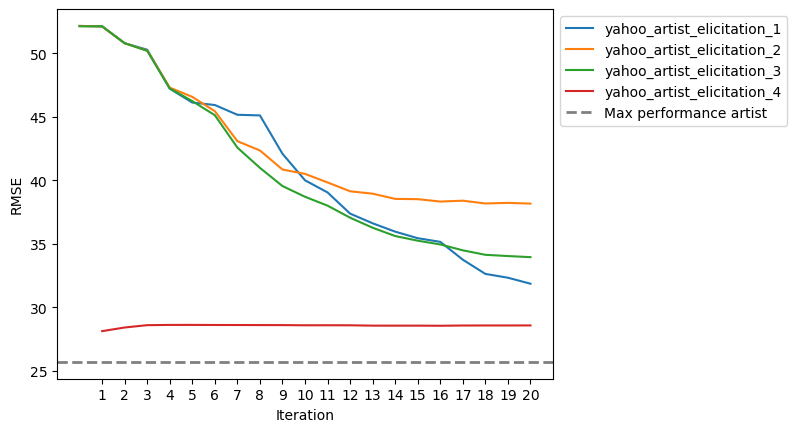

In [30]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
baseline_artist = 25.6939

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(yahoo_artist_elicitation_1)), yahoo_artist_elicitation_1, label='yahoo_artist_elicitation_1')
ax1.plot(np.arange(len(yahoo_artist_elicitation_2)), yahoo_artist_elicitation_2, label='yahoo_artist_elicitation_2')
ax1.plot(np.arange(len(yahoo_artist_elicitation_3)), yahoo_artist_elicitation_3, label='yahoo_artist_elicitation_3')
ax1.plot(np.arange(1, len(yahoo_artist_elicitation_4) + 1), yahoo_artist_elicitation_4, label='yahoo_artist_elicitation_4')
ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 21)) 
plt.savefig("yahoo_elicitations_output.pdf", format='pdf', bbox_inches='tight')
plt.show()

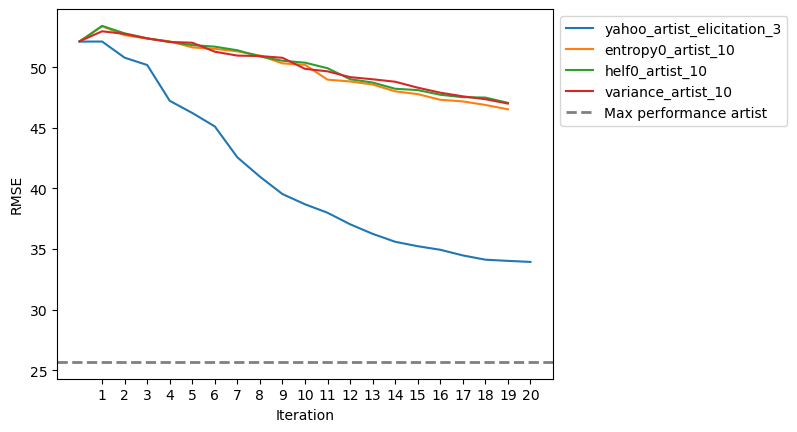

In [15]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
baseline_artist = 25.6939

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(yahoo_artist_elicitation_3)), yahoo_artist_elicitation_3, label='yahoo_artist_elicitation_3')
ax1.plot(np.arange(len(entropy0_artist_10)), entropy0_artist_10, label='entropy0_artist_10')
ax1.plot(np.arange(len(helf0_artist_10)), helf0_artist_10, label='helf0_artist_10')
ax1.plot(np.arange(len(variance_artist_10)), variance_artist_10, label='variance_artist_10')
# ax1.plot(np.arange(len(pop_artist_10)), pop_artist_10, label='pop_artist_10')
ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
# ax1.plot(x, pct_2[0], label='pct_2'
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 21)) 
plt.savefig("yahoo_p_np_output.pdf", format='pdf', bbox_inches='tight')
plt.show()

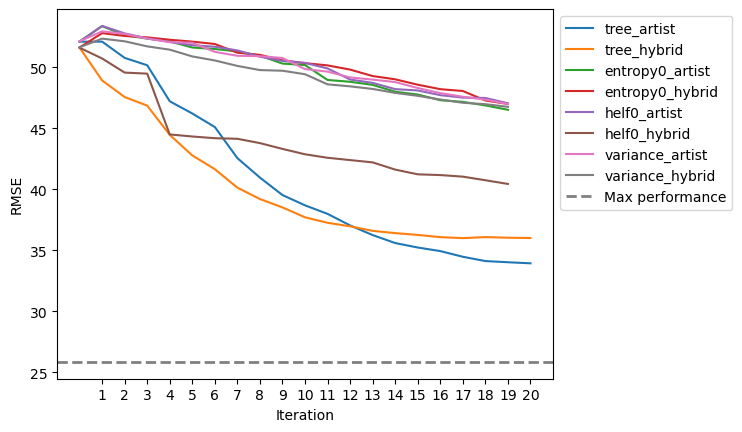

In [19]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
baseline_artist = 25.6939
baseline_hybrid = 25.8557
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(np.arange(len(pct_hybrid_10[0])), pct_hybrid_10[0], label='pct_hybrid_10')
# ax1.plot(np.arange(len(pct_artist_10[0])), pct_artist_10[0], label='pct_artist_10')
ax1.plot(np.arange(len(yahoo_artist_elicitation_3)), yahoo_artist_elicitation_3, label='tree_artist')
ax1.plot(np.arange(len(yahoo_hybrid_elicitation_3)), yahoo_hybrid_elicitation_3, label='tree_hybrid')
ax1.plot(np.arange(len(entropy0_artist_10)), entropy0_artist_10, label='entropy0_artist')
ax1.plot(np.arange(len(entropy0_hybrid_10)), entropy0_hybrid_10, label='entropy0_hybrid')

ax1.plot(np.arange(len(helf0_artist_10)), helf0_artist_10, label='helf0_artist')
ax1.plot(np.arange(len(helf0_hybrid_10)), helf0_hybrid_10, label='helf0_hybrid')

ax1.plot(np.arange(len(variance_artist_10)), variance_artist_10, label='variance_artist')
ax1.plot(np.arange(len(variance_hybrid_10)), variance_hybrid_10, label='variance_hybrid')
# ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
ax1.axhline(y=baseline_hybrid, color='gray', linestyle='--', linewidth=2, label='Max performance')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 21)) 
plt.savefig("yahoo_rq1_output.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
baseline_artist = 25.6939

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct1_artist_10[0])), pct1_artist_10[0], label='pct1_artist_10')
ax1.plot(np.arange(len(pct2_artist_10[0])), pct2_artist_10[0], label='pct2_artist_10')
ax1.plot(np.arange(len(pct3_artist_10[0])), pct3_artist_10[0], label='pct3_artist_10')
ax1.plot(np.arange(len(pct4_artist_10[0])), pct4_artist_10[0], label='pct4_artist_10')
ax1.plot(np.arange(len(entropy0_artist_10[0])), entropy0_artist_10[0], label='entropy0_artist_10')
ax1.plot(np.arange(len(helf0_artist_10[0])), helf0_artist_10[0], label='helf0_artist_10')
ax1.plot(np.arange(len(variance_artist_10[0])), variance_artist_10[0], label='variance_artist_10')
ax1.plot(np.arange(len(pop_artist_10[0])), pop_artist_10[0], label='pop_artist_10')
ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 21)) 

plt.show()
